## CNN classifier trained on Intel scenes dataset

Example image:

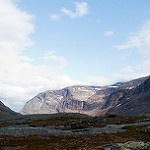

## Setup

In [ ]:
# Common imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Download data

In [ ]:
!wget -O archive.zip https://www.dropbox.com/s/2a05j4975hsjqb9/archive.zip?dl=1

## Unpack data to folder

In [ ]:
%rm -rf dataset
!unzip -q archive.zip -d ./dataset
!ls ./dataset

## Build dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="dataset/seg_train/seg_train",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150, 150),
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="dataset/seg_train/seg_train",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150, 150),
    validation_split=0.2,
    subset="validation",
    seed=42
)

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='dataset/seg_test/seg_test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150, 150))

## Visualize the data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # takes first batch consisting of 32 images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i].numpy()])
        plt.axis("off")

## Building a model

In [ ]:
model = keras.models.Sequential([
    # keras.Input(shape=(150, 150, 3)),
    keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding="SAME"),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=6, activation='softmax'),
])

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("CNNv4.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

## Training the model

In [ ]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

## Evaluating the model

In [ ]:
model.evaluate(test_ds)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):  # takes first batch consisting of 32 images
    for i in range(9):
        img_array = keras.preprocessing.image.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0)
        prediction = model.predict(img_array)        
        max_score_index = np.argmax(prediction[0], axis=0)
        score = float(prediction[0][max_score_index])
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img_array[0].numpy().astype("uint8"))
        plt.title("Predicted: " + classes[max_score_index] + " " + str(round(score * 100)) + "%\nActual: " + classes[labels[i]])
        plt.axis("off")